### Load libraries

In [1]:
from ast import literal_eval
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("ggplot")

In [2]:
df = pd.read_csv("ipip.csv").rename(columns={"front": "prompt_in_front"})

df.body = df.body.astype(bool)
df.prompt_in_front = df.prompt_in_front.astype(bool)
df.binarized = df.binarized.astype(bool)

df["n_classes"] = df.classes.str.count(",") + 1
df["baseline_acc"] = 1 / df.n_classes
df["baseline_loss"] = -np.log(df.baseline_acc)

assert len(df[(df.binarized & (df.n_classes != 2))]) == 0
assert len(df[(~df.binarized & (df.n_classes == 2))]) == 0

print(len(df))
df.head()

3320


,prompt,classes,answer_index,source_dataset,body,Q_id,prompt_in_front,binarized,n_classes,baseline_acc,baseline_loss
0,"For the following statement, choose whether it...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,ipip,False,0,False,False,5,0.2,1.609438
1,"For the following statement, choose whether it...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,ipip,False,1,False,False,5,0.2,1.609438
2,"For the following statement, choose whether it...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,ipip,False,2,False,False,5,0.2,1.609438
3,"For the following statement, choose whether it...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,ipip,False,3,False,False,5,0.2,1.609438
4,"For the following statement, choose whether it...","[' 1', ' 2', ' 3', ' 4', ' 5']",0,ipip,False,4,False,False,5,0.2,1.609438


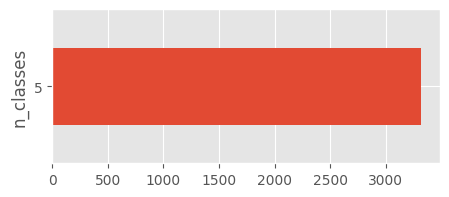

In [3]:
plt.figure(figsize=(5, 2))
df.groupby("n_classes").size().plot.barh();

### Load evaluation results

In [4]:
CSV_MAP: dict[str, str] = {
    "ada": "ada.csv",
    "babbage": "babbage.csv",
    "curie": "curie.csv",
    "davinci": "davinci.csv",
    "ada_rlhf": "text-ada-001.csv",
    "babbage_rlhf": "text-babbage-001.csv",
    "curie_rlhf": "text-curie-001.csv",
    "davinci_rlhf": "text-davinci-001.csv",
    "opt_125m": "opt-125m.csv",
    "opt_350m": "opt-350m.csv",
    "opt_1_3b": "opt-1.3b.csv",
    "opt_2_7b": "opt-2.7b.csv",
}

GPT3_SIZES = {
    # GPT-3 sizes are based on https://blog.eleuther.ai/gpt3-model-sizes/
    "ada": 350_000_000,
    "babbage": 1_300_000_000,
    "curie": 6_700_000_000,
    "davinci": 175_000_000_000,
}

GPT3_RLHF_SIZES = {
    "ada_rlhf": 350_000_000,
    "babbage_rlhf": 1_300_000_000,
    "curie_rlhf": 6_700_000_000,
    "davinci_rlhf": 175_000_000_000,
}

OPT_SIZES = {
    # opt sizes from their names
    "opt_125m": 125_000_000,
    "opt_350m": 350_000_000,
    "opt_1_3b": 1_300_000_000,
    "opt_2_7b": 2_700_000_000,
}

OGPT_SIZES = {"opt_125m": 125_000_000} | GPT3_SIZES

In [6]:
for model_name, path in CSV_MAP.items():
    cur_df = pd.read_csv("results_full/v1/" + path)

    assert len(df) == len(cur_df)

    # Parse probs
    probs_mat = np.array([literal_eval(x) for x in cur_df.probs])
    for i in range(probs_mat.shape[1]):
        df[f"prob_{model_name}_{i}"] = probs_mat[:, i]
        df[f"pred_{model_name}"] = probs_mat.argmax(axis=1)

df.columns.sort_values()

Index(['Q_id', 'answer_index', 'baseline_acc', 'baseline_loss', 'binarized',
       'body', 'classes', 'n_classes', 'pred_ada', 'pred_ada_rlhf',
       'pred_babbage', 'pred_babbage_rlhf', 'pred_curie', 'pred_curie_rlhf',
       'pred_davinci', 'pred_davinci_rlhf', 'pred_opt_125m', 'pred_opt_1_3b',
       'pred_opt_2_7b', 'pred_opt_350m', 'prob_ada_0', 'prob_ada_1',
       'prob_ada_2', 'prob_ada_3', 'prob_ada_4', 'prob_ada_rlhf_0',
       'prob_ada_rlhf_1', 'prob_ada_rlhf_2', 'prob_ada_rlhf_3',
       'prob_ada_rlhf_4', 'prob_babbage_0', 'prob_babbage_1', 'prob_babbage_2',
       'prob_babbage_3', 'prob_babbage_4', 'prob_babbage_rlhf_0',
       'prob_babbage_rlhf_1', 'prob_babbage_rlhf_2', 'prob_babbage_rlhf_3',
       'prob_babbage_rlhf_4', 'prob_curie_0', 'prob_curie_1', 'prob_curie_2',
       'prob_curie_3', 'prob_curie_4', 'prob_curie_rlhf_0',
       'prob_curie_rlhf_1', 'prob_curie_rlhf_2', 'prob_curie_rlhf_3',
       'prob_curie_rlhf_4', 'prob_davinci_0', 'prob_davinci_1',
     

### High level statistics about predictions

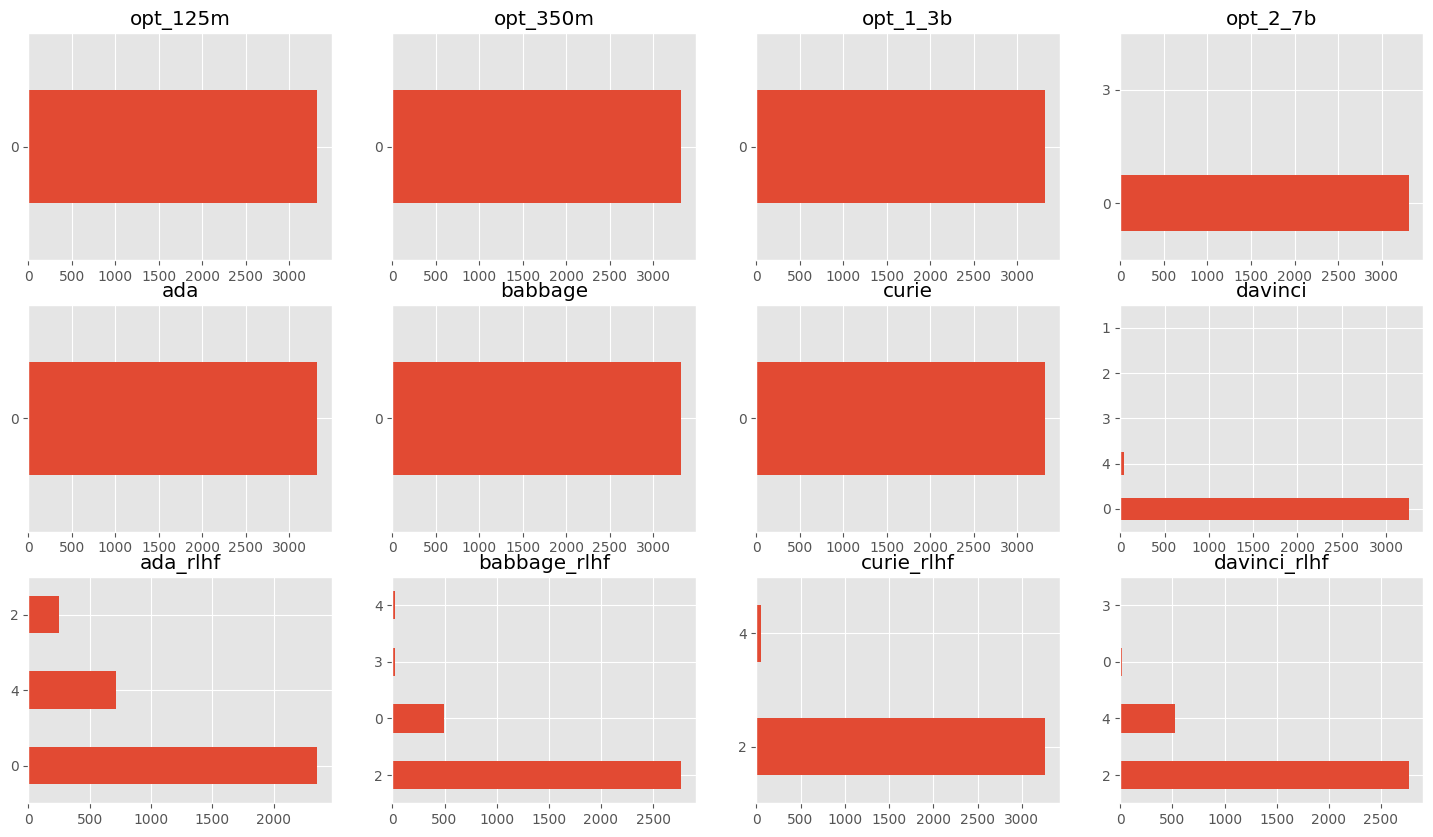

In [7]:
# Distribution of predictions
plt.figure(figsize=(18, 10))
for i, model_list in enumerate([OPT_SIZES.keys(), GPT3_SIZES.keys(), GPT3_RLHF_SIZES.keys()]):
    for j, model_name in enumerate(model_list):
        plt.subplot(3, 4, 4 * i + j + 1)
        df[f"pred_{model_name}"].value_counts().plot.barh();
        plt.title(model_name)

### Cherry-picking

In [ ]:
df["gpt3_diff0"] = (df.prob_babbage_0 - df.prob_davinci_0).abs()
df["gpt3_diff0"] = (df.prob_davinci_0 - df.prob_davinci_4).abs()

### Plotting code

In [ ]:
filt = "|".join([
    "(prob_babbage_0 > prob_davinci_0)",
    "(prob_babbage_4 > prob_davinci_4)",
    "(prob_babbage_0 < prob_davinci_0)",
    "(prob_babbage_4 < prob_davinci_4)",
])
len(df.query(filt))

In [ ]:
def gen_plots(
    df: pd.DataFrame,
    size_dict: dict[str, int],
    title: str = "",
):
    models = list(size_dict.keys())
    sizes = np.array(list(size_dict.values()))

    losses = np.array([df[f"loss_{m}"].mean() for m in models])
    loss_errs = np.array([df[f"loss_{m}"].std() for m in models]) / np.sqrt(len(df))
    accs = np.array([df[f"correct_{m}"].mean() for m in models])
    partial_accs = np.array([df[f"partial_credit_{m}"].mean() for m in models])

    plt.figure(figsize=(16, 3))
    plt.suptitle(title + f" (n={len(df)})")
    plt.tight_layout()

    def common_plot_setup(baseline: float):
        plt.axhline(
            baseline,
            linestyle="--",
            color="black",
            zorder=-1,
            label="random baseline",
        )
        plt.xscale("log")
        # plt.xlabel("Model size")
        plt.xticks(sizes, models)
        plt.legend()

    # Loss
    plt.subplot(1, 3, 1)
    plt.errorbar(sizes, losses, loss_errs, label="loss")
    plt.yscale("log")
    common_plot_setup(df.baseline_loss.mean())

    # Acc
    plt.subplot(1, 3, 2)
    plt.plot(sizes, accs, label="acc.")
    plt.ylim(-0.02, 1.02)
    common_plot_setup(df.baseline_acc.mean())

    # Partial acc
    plt.subplot(1, 3, 3)
    plt.plot(sizes, partial_accs, label="partial acc.")
    plt.ylim(-0.02, 1.02)
    common_plot_setup(0.5)

gen_plots(df, OGPT_SIZES, title="opt-125m + gpt3 scaling")

### Time for some inverse scaling!